In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.individual import Individual
from utils.draw import draw
import utils.protectedOperators as pOps

In [8]:
NUM_ISLANDS = 7
ISLAND_POPULATION = 125
GENERATIONS = 1000
MAX_DEPTH = 11
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 150
MIGRATION_SIZE = 4
PRINT_INTERVAL = 100
INDIVIDUAL_ATTEMPTS = 10
TEST_TRAIN = 0.7
STAGNATION_THRESHOLD = 60

POPULATION_SIZE = NUM_ISLANDS * ISLAND_POPULATION

In [9]:
def plot_fitness_trend(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

def plot_predictions(y_test, y_pred, fitness):
    sorted_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Actual vs Predicted - Fitness: {fitness:.4f}")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
class SymbolicRegressionMC:
    def __init__(self, xTrain, yTrain,
                 populationSize=POPULATION_SIZE,
                 generations=GENERATIONS,
                 maxDepth=MAX_DEPTH,
                 individualAttempts=INDIVIDUAL_ATTEMPTS,
                 tournamentSize=TOURNAMENT_SIZE,
                 numIslands=NUM_ISLANDS,
                 mutationRate=MUTATION_RATE,
                 migrationInterval=MIGRATION_INTERVAL,
                 migrationSize=MIGRATION_SIZE,
                 stagnationThreshold=STAGNATION_THRESHOLD,
                 printInterval=PRINT_INTERVAL,
                 refreshFraction=0.2,
                 mcBiasProb=0.6,
                 penaltyLambda=1e-3,
                 maxNodes=250,
                 earlyStopPatience=None):
        # Data / hyperparams
        self.xTrain = xTrain
        self.yTrain = yTrain
        self.populationSize = populationSize
        self.generations = generations
        self.maxDepth = maxDepth
        self.individualAttempts = individualAttempts
        self.tournamentSize = tournamentSize
        self.printInterval = printInterval

        # GP / island params
        self.numIslands = numIslands
        self.islandSize = max(2, self.populationSize // max(1, self.numIslands))
        self.mutationRate = mutationRate
        self.migrationInterval = migrationInterval
        self.migrationSize = migrationSize

        # Monte Carlo / stagnation
        self.stagnationThreshold = stagnationThreshold
        self.refreshFraction = refreshFraction
        self.mcBiasProb = mcBiasProb  # bias toward mutating elites

        # Other controls
        self.penaltyLambda = penaltyLambda   # complexity penalty factor
        self.MAX_NODES = maxNodes            # bloat control on recombined children
        self.earlyStopPatience = earlyStopPatience or int(self.generations * 0.25)

        # internals
        self.populations = []  # list of islands: each is list of Individuals
        self.bestIndividual = None
        self.bestFitness = float('inf')  # penalized fitness tracked
        self.fitnessHistory = []

    # ---------------------------
    # Initialization / helpers
    # ---------------------------
    def initializePopulation(self):
        """Initialize islands with random individuals (valid fitness only)."""
        self.populations = []
        for _ in range(self.numIslands):
            island = []
            while len(island) < self.islandSize:
                ind = Individual(self.maxDepth, self.xTrain, self.yTrain, self.individualAttempts)
                ind.generate()
                if np.isfinite(ind.fitness):
                    island.append(ind)
            self.populations.append(island)

    def _computePenalizedFitness(self, pop):
        """Attach penalized fitness (_pf) to each individual."""
        for ind in pop:
            try:
                size = ind.size()
            except Exception:
                size = 0
            ind._pf = ind.fitness + self.penaltyLambda * size

    def _clearPenalizedMarks(self, pop):
        for ind in pop:
            if hasattr(ind, "_pf"):
                del ind._pf

    # ---------------------------
    # Selection
    # ---------------------------
    def tournamentSelection(self, population, k=None):
        k = k or self.tournamentSize
        k = min(k, len(population))
        participants = random.sample(population, k)
        participants.sort(key=lambda ind: getattr(ind, "_pf", ind.fitness))
        weights = [k - i for i in range(k)]
        return random.choices(participants, weights=weights, k=1)[0]

    def monteCarloParent(self, population, temperature, sample_k=3):
        """
        Monte Carlo selection with normalized fitness within the sample.
        Uses penalized fitness (_pf) if available.
        """
        if temperature <= 0:
            return min(population, key=lambda ind: getattr(ind, "_pf", ind.fitness))

        sample_k = min(sample_k, len(population))
        sample = random.sample(population, sample_k)

        # collect penalized fitnesses
        fits = np.array([getattr(ind, "_pf", ind.fitness) for ind in sample], dtype=float)
        # normalize to [0,1] where 0 = best
        minf, maxf = fits.min(), fits.max()
        span = (maxf - minf) if maxf > minf else 1.0
        norm = (fits - minf) / span

        # candidate and reference
        idx_cand = random.randrange(len(sample))
        cand = sample[idx_cand]
        idxRef = int(np.argmin(norm))
        ref = sample[idxRef]

        delta = norm[idx_cand] - norm[idxRef]
        if delta <= 0:
            return cand
        # acceptance probability (temperature on normalized scale)
        try:
            acceptance = np.exp(-delta / temperature)
        except OverflowError:
            acceptance = 0.0
        if random.random() < acceptance:
            return cand
        return ref

    # ---------------------------
    # Migration & refresh
    # ---------------------------
    def migrate(self):
        for i in range(self.numIslands):
            source = self.populations[i]
            # choose direction with small probability reversed
            if random.random() < 0.25:
                targetIndex = (i - 1) % self.numIslands
            else:
                targetIndex = (i + 1) % self.numIslands
            target = self.populations[targetIndex]

            sortedSource = sorted(source, key=lambda ind: getattr(ind, "_pf", ind.fitness))
            numElite = max(1, self.migrationSize // 2)
            numRand = self.migrationSize - numElite
            elites = sortedSource[:numElite]
            innovators = random.sample(source, min(numRand, len(source)))
            migrants = elites + innovators

            worstTarget = sorted(target, key=lambda ind: getattr(ind, "_pf", ind.fitness), reverse=True)
            for m, w in zip(migrants, worstTarget):
                if getattr(m, "_pf", m.fitness) < getattr(w, "_pf", w.fitness):
                    idx = target.index(w)
                    target[idx] = m.clone()
            self.populations[targetIndex] = target

    def mcRefresh(self, island, dynamicFraction):
        """Replace worst individuals in island with biased new ones."""
        island.sort(key=lambda ind: getattr(ind, "_pf", ind.fitness))
        numReplace = int(len(island) * dynamicFraction)
        if numReplace <= 0:
            return island
        survivors = island[:-numReplace]
        newInds = []
        attempts = 0

        while len(newInds) < numReplace and attempts < max(500, numReplace * 10):
            attempts += 1
            if random.random() < self.mcBiasProb and len(survivors) > 0:
                donorPool = survivors[:max(1, len(survivors) // 4)]
                donor = random.choice(donorPool).clone()
                donor.mutate()
                if np.isfinite(donor.fitness):
                    newInds.append(donor)
            else:
                individual = Individual(self.maxDepth, self.xTrain, self.yTrain, self.individualAttempts)
                individual.generate()
                if np.isfinite(individual.fitness):
                    newInds.append(individual)

        # If still short, fill by mutating survivors
        while len(newInds) < numReplace:
            donor = random.choice(survivors).clone()
            donor.mutate()
            newInds.append(donor)

        newIsland = survivors + newInds
        return newIsland

    # ---------------------------
    # Evolution loop
    # ---------------------------
    def evolve(self):
        self.initializePopulation()
        stagnationCount = 0
        islandStagnation = [0] * self.numIslands

        T0, T_min, tempDecay = 1.0, 0.01, 0.98
        mutationRate, minMutRate, mutationDecay = 0.5, 0.2, 0.995
        penaltyLambda = 0.002
        temperature = T0

        for gen in tqdm(range(self.generations), desc="Generations"):
            for idx in range(self.numIslands):
                currentPop = self.populations[idx]
                for ind in currentPop:
                    ind.fitness = ind.fitness + penaltyLambda * ind.size()

                newPop = []
                elite = min(currentPop, key=lambda ind: ind.fitness)
                newPop.append(elite.clone())

                mcProb = max(0.05, 0.5 * (1 - gen / (self.generations * 0.7)))
                if islandStagnation[idx] > self.stagnationThreshold // 3:
                    mcProb *= 2.0

                while len(newPop) < self.islandSize:
                    if random.random() < mutationRate:
                        if random.random() < mcProb:
                            parent = self.monteCarloParent(currentPop, temperature, 4)
                        else:
                            parent = self.tournamentSelection(currentPop)
                        child = parent.clone()
                        child.mutate()
                        newPop.append(child)
                    else:
                        if random.random() < mcProb:
                            p1 = self.monteCarloParent(currentPop, temperature, 4)
                            p2 = self.monteCarloParent(currentPop, temperature, 4)
                        else:
                            p1 = self.tournamentSelection(currentPop)
                            p2 = self.tournamentSelection(currentPop)
                        if p1 is p2:
                            p2 = random.choice(currentPop)
                        c1, c2 = p1.crossover(p2)
                        newPop.extend([c1, c2])

                combined = currentPop + newPop
                combined.sort(key=lambda ind: ind.fitness)
                bestBefore = currentPop[0].fitness
                self.populations[idx] = combined[:self.islandSize]

                if self.populations[idx][0].fitness < bestBefore:
                    islandStagnation[idx] = 0
                else:
                    islandStagnation[idx] += 1

            if (gen + 1) % 100 == 0:
                self.migrate()

            improve = False
            for island in self.populations:
                bestIsland = min(island, key=lambda ind: ind.fitness)
                if bestIsland.fitness < self.bestFitness:
                    self.bestFitness = bestIsland.fitness
                    self.bestIndividual = bestIsland.clone()
                    improve = True

            self.fitnessHistory.append(self.bestFitness)

            if improve:
                stagnationCount = 0
            else:
                stagnationCount += 1

            if stagnationCount >= self.stagnationThreshold:
                print(f"Gen {gen+1} - Full stagnation: refreshing islands and reheating")
                for i in range(self.numIslands):
                    self.populations[i] = self.mcRefresh(self.populations[i], self.refreshFraction)
                    islandStagnation[i] = 0
                temperature, mutationRate, stagnationCount = T0, 0.5, 0

            temperature = max(T_min, temperature * tempDecay)
            mutationRate = max(minMutRate, mutationRate * mutationDecay)

            if (gen + 1) % self.printInterval == 0:
                print(f"Gen {gen+1} | Best fitness: {self.bestFitness:.6f} | "
                      f"Temp: {temperature:.3f} | MutRate: {mutationRate:.3f} | "
                      f"Formula: {self.bestIndividual}")

        return self.bestIndividual, self.fitnessHistory


In [11]:
def runSymbolicRegressionMC(problemNum):
    problem = np.load(f'./data/problem_{problemNum}.npz')
    xData, yData = problem['x'], problem['y']
    perm = np.random.permutation(len(yData))
    xData = xData[:, perm]
    yData = yData[perm]

    trainSize = int(TEST_TRAIN * len(yData))
    xTrain, yTrain = xData[:, :trainSize], yData[:trainSize]
    xTest, yTest = xData[:, trainSize:], yData[trainSize:]

    mc = SymbolicRegressionMC(xTrain, yTrain)
    print(f"\nProblem {problemNum}")
    bestIndividual, history = mc.evolve()

    testIndividual = bestIndividual.clone()
    testIndividual.xTrain = xTest
    testIndividual.yTrain = yTest
    yPred = testIndividual.computeFitness(True)

    print("Best Formula:", bestIndividual)
    print("Train fitness:", bestIndividual.fitness)
    print("Test fitness:", testIndividual.fitness)

    #bestIndividual.plot()
    plot_fitness_trend(history)
    plot_predictions(yTest, yPred, testIndividual.fitness)


Problem 2


Generations:  10%|█         | 100/1000 [04:28<58:43,  3.91s/it]

Gen 100 | Best fitness: 8633828713742.266602 | Temp: 0.133 | MutRate: 0.303 | Formula: mul(sub(max(atan(exp(exp(log(-1)))), sub(mul(min(x2, sqrt(max(x0, 0))), mod(x1, sub(x2, acos(x0)))), sub(sub(x1, log(-1)), log(-1)))), sub(-1, sub(log(sub(x1, log(-1))), sub(max(x0, 0), log(-1))))), sub(asin(mod(neg(atan(sqr(2.30259))), min(neg(max(add(x2, sub(mul(x0, 2.71828), neg(x1))), -1)), exp(x0)))), abs(min(neg(log2(max(add(x2, sub(mul(x0, 1.73205), neg(x1))), -1))), max(x2, asin(sub(exp(min(x2, sqrt(x2))), log(-1))))))))


Generations:  20%|██        | 200/1000 [12:55<1:22:43,  6.20s/it]

Gen 200 | Best fitness: 5760952165513.188477 | Temp: 0.018 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(sub(x1, acos(x0)), neg(x1)), 0))), mod(x1, sub(x2, sub(min(x0, sqrt(-1)), acos(x0))))), sub(sub(sub(sub(mul(x0, x0), acos(x0)), neg(x1)), log(-1)), log(0))), sub(neg(max(exp(exp(log(-1))), add(x2, sub(mul(x0, 2.71828), neg(x1))))), sub(log(sub(mul(min(x0, sqrt(-1)), mod(max(x1, atan(2)), x0)), log(acos(log(-1))))), sub(0, log(-1))))), sub(asin(mod(neg(atan(sqr(neg(atan(sqr(2.30259)))))), min(neg(max(add(x2, sub(mul(x0, 2.71828), neg(x1))), -1)), exp(x0)))), abs(min(neg(log2(max(add(x2, sub(mul(x0, 1.73205), neg(x1))), neg(atan(sqr(2.30259)))))), sub(mul(min(x2, sqrt(max(x0, 0))), mod(x1, sub(sub(x1, log(-1)), acos(x0)))), sub(sub(mul(exp(x0), x2), log(-1)), min(0, min(x0, sqrt(-1)))))))))


Generations:  30%|███       | 300/1000 [24:16<1:24:14,  7.22s/it]

Gen 300 | Best fitness: 4178902575250.161621 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(mul(min(x1, sqrt(max(x0, 0))), pow(x0, max(x0, div(x0, acos(x2))))))), mod(x1, sub(-1, acos(x0)))), sub(sub(exp(neg(neg(sub(mul(x0, x1), neg(x1))))), acos(add(x2, sub(mul(x0, 1.73205), neg(x1))))), acos(x0))), sub(mul(x0, mod(sub(-1, log(x1)), sub(x2, acos(x1)))), sub(log(sub(mul(x0, mod(sub(0, x1), mod(min(x2, sin(x0)), mul(x2, x1)))), log(add(x2, sub(mul(x0, 2.71828), neg(x1)))))), sub(sub(mul(min(x2, max(x0, x1)), mod(sub(sin(x0), log(-1)), sub(x2, acos(x0)))), acos(add(x2, sub(mul(x0, 1.73205), neg(x1))))), sub(acos(add(x2, sub(mul(x0, 1.73205), neg(x1)))), sub(x2, log(-1))))))), sub(asin(mod(neg(atan(atan(exp(exp(log(-1)))))), min(neg(max(add(x2, sub(mul(x0, 2.71828), neg(x1))), -1)), exp(add(x1, sub(mul(x0, 1.73205), neg(x1))))))), abs(min(neg(log2(max(add(x2, sub(mul(x0, 1.73205), neg(x1))), 0))), max(x2, asin(sub(exp(min(x1, x0)), add(x2, sub(mul(x1, mul(x2, x1)),

Generations:  40%|████      | 400/1000 [36:15<1:20:46,  8.08s/it]

Gen 400 | Best fitness: 3428803666498.725586 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(sub(x1, acos(x0)), neg(x1)), cbrt(atan(atan(log(x0))))))), mod(x1, sub(mul(exp(mul(x1, atan(2))), x1), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), cbrt(-1))))))), sub(sub(sub(sub(exp(mul(x0, x1)), acos(x0)), neg(atan(x2))), acos(add(x2, sub(mul(x0, 1.73205), neg(x1))))), log(sub(mul(min(x2, x1), mod(max(max(x0, x2), atan(2.71828)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(x2, x1), mod(max(2, atan(2)), x0)), log(acos(log(-1)))))), sub(log(sub(mul(min(x1, sqrt(x0)), mod(mul(x0, 1.73205), x0)), log(log10(tanh(mul(x2, sinh(2))))))), sub(sqrt(abs(3.14159)), acos(add(x2, sub(mul(x0, 1.73205), neg(x1)))))))), sub(asin(mod(neg(atan(sqr(neg(atan(sqr(2.30259)))))), min(neg(max(add(x2, sub(mul(x0, 2.71828), neg(x1))), -1)), exp(x0)))), abs(min(neg(log2(max(add(x2, sub(mul(x0, 1.73205), neg(x1))), neg(add(abs(neg(x1)), 1.73205))))), sub(mul(m

Generations:  50%|█████     | 500/1000 [49:39<1:10:02,  8.40s/it]

Gen 500 | Best fitness: 3062211343160.781250 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(sub(1.61803, max(x1, x0)), 0), cbrt(atan(atan(log(x0))))))), mod(x1, sub(mul(exp(x0), x1), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(x0, x1)), acos(mod(mul(x0, 1.73205), x0))), add(max(x1, 0), sub(neg(0.693147), neg(x1)))), acos(add(x2, sub(sub(mul(x0, 1.73205), -1), neg(x1))))), log(sub(mul(min(max(x0, x2), x1), mod(max(max(x2, x2), atan(2.71828)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(x2, x1), mod(max(1.73205, atan(x1)), x0)), log(acos(log(-1)))))), sub(log(sub(mul(min(x1, sqrt(x0)), mod(mul(x0, 1.73205), x0)), log(log10(tanh(mul(x2, sinh(2))))))), sub(exp(mul(min(1.73205, x1), mod(max(x2, atan(2)), x0))), acos(add(x2, sub(mul(x0, 1.73205), neg(x1)))))))), sub(asin(mod(neg(atan(sqr(neg(atan(sqr(1.73205)))))), min(neg(max(add(x2, sub(mul(x0, 2.71828), neg(x1))), -1)), mul(x0, x0)))), ab

Generations:  60%|██████    | 600/1000 [1:04:13<1:02:03,  9.31s/it]

Gen 600 | Best fitness: 2643305443848.711426 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(neg(x1), neg(sub(x0, x0))), cbrt(atan(atan(log(x0))))))), mod(x1, sub(mul(exp(mul(x1, atan(acos(x0)))), min(sub(mul(x0, 1.73205), neg(x1)), sqrt(sinh(2.30259)))), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(x0, x1)), acos(x0)), sub(cbrt(atan(x2)), neg(x1))), acos(add(x2, sub(mul(x0, sqrt(add(1.73205, 0.5))), neg(x1))))), log(sub(mul(min(x2, sqrt(x0)), mod(max(max(min(x1, 2.30259), x2), atan(3.14159)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(x1)), sqrt(sinh(2.30259))), add(sub(x2, -1), sub(mul(x0, 2.71828), neg(x1)))), acos(add(x2, sub(mul(x0, 1.73205), neg(x1))))))), sub(log(sub(mul(min(min(x1, sqrt(x0)), sqrt(x0)), mod(mul(x0, 1.73205), x0)), log(log10(tanh(mul(x2, sinh(2))))))), sub(mul(min(mul(mul(x0, 1.73205), sqr(x0)), sqrt(x0)), add(sub(x2, x0), sub(sub(mul(x0

Generations:  70%|███████   | 700/1000 [1:19:18<46:20,  9.27s/it]  

Gen 700 | Best fitness: 2221603325964.853516 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(neg(x1), x1), cbrt(atan(x2))))), mod(x1, sub(mul(exp(mul(x1, atan(acos(x0)))), min(sub(mul(x0, 1.73205), neg(x1)), sub(mul(x0, 1.73205), neg(x1)))), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(cbrt(x0), x1)), acos(x0)), sub(mul(sqr(x0), sin(x1)), sub(x0, x1))), acos(add(x2, sub(mul(x0, sqrt(add(1.73205, 0.5))), neg(x1))))), log(sub(mul(min(x2, sqrt(sin(x1))), mod(max(max(min(x1, 2.30259), x2), atan(2.71828)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(x1)), sqrt(sinh(2.30259))), add(sub(x2, -1), sub(mul(x0, 2.71828), neg(x1)))), acos(add(sub(x2, cbrt(x0)), sub(mul(x0, 1.73205), neg(x1))))))), sub(log(sub(mul(min(min(x1, sqrt(x0)), sqrt(x0)), mod(mul(x0, 1.73205), x0)), log(log10(tanh(mul(x2, sinh(2))))))), sub(mul(min(mul(sub(mul(x0, 1.73205), neg(x1)), sqr(x0)), sqrt(

Generations:  80%|████████  | 800/1000 [1:35:20<32:49,  9.85s/it]

Gen 800 | Best fitness: 1968236161936.161133 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(atan(neg(x1)), x1), cbrt(atan(3.14159))))), mod(x1, sub(mul(exp(mul(x0, atan(acos(x0)))), min(sub(mul(x1, 1.73205), neg(x1)), sub(log(-1), neg(x1)))), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(cbrt(x0), x1)), acos(x0)), sub(mul(sqr(mul(x0, 2.71828)), max(sinh(2), 1.73205)), sub(neg(x1), x1))), acos(add(x2, sub(mul(x0, sqrt(add(1.73205, 0.5))), neg(x1))))), log(sub(mul(min(x2, sqrt(sin(x1))), mod(max(max(min(x1, 2.30259), x2), atan(2.71828)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(3.14159)), exp(mul(x0, 1.73205))), add(x2, sub(mul(x0, 2.71828), neg(x1)))), acos(add(sub(x2, cbrt(x0)), sub(mul(x0, 1.73205), neg(x1))))))), sub(log(sub(mul(min(min(x1, sqrt(x2)), sqrt(x0)), mod(mul(x0, 1.73205), x0)), log(log10(tanh(mul(x2, sinh(2))))))), sub(mul(min(mul(sub(mul(x0, 1.

Generations:  90%|█████████ | 900/1000 [1:52:18<17:07, 10.28s/it]

Gen 900 | Best fitness: 1805778088145.612305 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(neg(x1), x1), neg(x1)))), mod(x1, sub(mul(exp(mul(x0, atan(acos(x0)))), min(sub(mul(x1, 1.73205), neg(x1)), sub(log(-1), neg(x1)))), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(cbrt(x0), x1)), acos(x0)), sub(mul(sqr(mul(x0, 3.14159)), max(sinh(2), 1.73205)), sub(neg(x1), neg(x2)))), acos(add(x2, sub(mul(x0, sqrt(add(1.73205, 0.5))), neg(x1))))), log(sub(mul(min(x2, sqrt(mul(x0, 1.73205))), mod(max(max(min(x1, 2.30259), x2), mul(x0, 1.73205)), x0)), log(acos(abs(3.14159))))))), sub(neg(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(3.14159)), sin(sub(x1, log10(0)))), add(x2, sub(mul(x0, 2.71828), neg(x1)))), acos(add(sub(x2, cbrt(x0)), sub(mul(x0, 2), neg(x1))))))), sub(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(3.14159)), exp(mul(3.14159, 1.73205))), add(x2, sub(mul(x0, 2.71828), neg(x1)))), acos(add(sub(x2, cbrt(x0

Generations: 100%|██████████| 1000/1000 [2:10:08<00:00,  7.81s/it]

Gen 1000 | Best fitness: 1663035734634.482178 | Temp: 0.010 | MutRate: 0.200 | Formula: mul(sub(sub(mul(min(x2, sqrt(max(sub(neg(x1), x1), neg(x1)))), mod(x1, sub(mul(exp(mul(x0, atan(acos(x0)))), min(sub(mul(x1, 1.73205), neg(x1)), sub(log(-1), neg(x1)))), sub(mul(exp(mul(x0, 1.73205)), 1.73205), acos(div(atan(x0), atan(2))))))), sub(sub(sub(sub(exp(mul(cbrt(x0), x1)), acos(sub(mul(x0, 3.14159), neg(x1)))), sub(mul(sqr(mul(x0, 3.14159)), max(sqr(2.30259), 1.73205)), sub(mul(min(sub(1.61803, 1.41421), sub(x2, -1)), 3.14159), sub(mul(x0, 3.14159), neg(x1))))), acos(add(x2, sub(mul(x0, sqrt(add(1.73205, 0.5))), neg(x1))))), log(sub(mul(min(x2, sqrt(mul(x2, 1.73205))), mod(max(max(min(x1, 2.30259), x2), mul(x0, 0.693147)), x0)), log(acos(mul(mul(x0, sqrt(x0)), sqr(3.14159)))))))), sub(neg(log(sub(mul(min(mul(mul(x0, 1.73205), sqr(3.14159)), exp(mul(3.14159, 1.73205))), add(x2, sub(mul(x0, 2.71828), neg(x1)))), acos(add(sub(x2, cbrt(x0)), sub(mul(x0, 2), neg(x1))))))), sub(log(sub(mul(min(

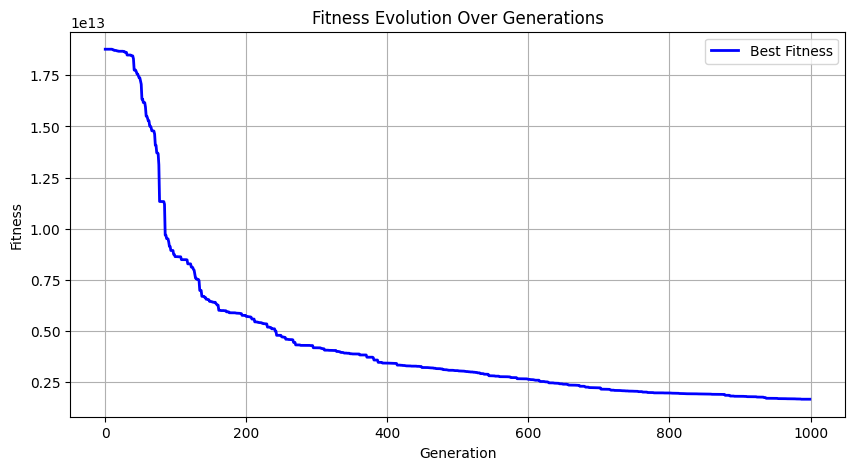

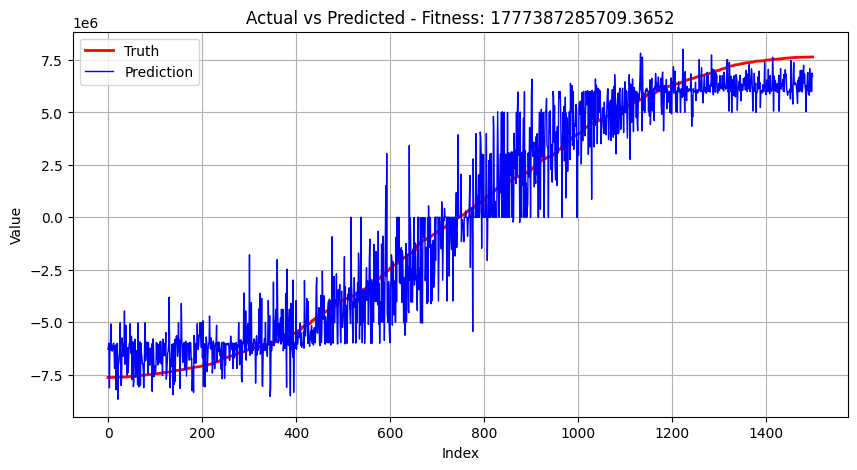

In [12]:

np.seterr(all='ignore')
runSymbolicRegressionMC(2)